## BERT Classifier for Eng Hardware


In [1]:
#import libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
import tensorflow_text as text

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

#hide warnings
import warnings
warnings.filterwarnings('ignore')


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

c:\Users\mattl\anaconda3\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\mattl\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [106]:
# Read recipe inputs
# Dataset pharmacy_dataset_reduced renamed to pharmacy_dataset_TEST by vkb6bn on 2023-03-08 17:42:52
#data = pd.read_csv('prtspr_linked_tickets_s03_spans_joined_cleaned.csv')
data = pd.read_csv('software_tickets.csv')
len(data)

2336

In [6]:
data.tail(5)

,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware0_value,eng_hardware1_value,eng_hardware2_value,eng_location0_value,eng_location1_value,eng_location2_value,ict_components_0,ict_components_1,ict_components_2,ict_components,ict_description,ict_summary
2331,ICT-9762,PRTSPR-25226,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07 Operations Software Support,NaN,NaN,07 Operations Software Support,There have been a few instances of Archive cra...,Archive runing out of memmory
2332,ICT-5721,PRTSPR-26898,"[""AntennaContainerCrash""]",software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12-01 Alarm System and Monitoring,NaN,NaN,12-01 Alarm System and Monitoring,DA52 container crashed with the following BT:\...,Antenna container crash destroying a MonitorBlob
2333,ICT-9810,PRTSPR-29658,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03-05 QuickLook,NaN,NaN,03-05 QuickLook,"During observations, it happens that sometimes...",Sometimes Quicklook starts repeating uid entri...
2334,ICT-11530,PRTSPR-29834,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07 Operations Software Support,NaN,NaN,07 Operations Software Support,This ticket has a a purpose to determine the e...,Patch compilation and deployment procedure
2335,ICT-19106,PRTSPR-52452,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03 Control,NaN,NaN,03 Control,At [https://jira.alma.cl/browse/PRTSPR-52165 |...,"MountController thread (apparently) stuck, not..."


In [107]:
data['desc_strip_nl'] =data['ict_description'].str.split(r'\n', expand=True)[0]
data['desc_strip_nl_nl'] =data['ict_description'].str.split(r'\n\n', expand=True)[0]
data['desc_strip_nofmt'] =data['ict_description'].str.split(r'{noformat}', expand=True)[0]

In [108]:
data

,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware0_value,eng_hardware1_value,eng_hardware2_value,...,eng_location2_value,ict_components_0,ict_components_1,ict_components_2,ict_components,ict_description,ict_summary,desc_strip_nl,desc_strip_nl_nl,desc_strip_nofmt
0,ICT-3010,PRTSPR-21519,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,07 Operations Software Support,NaN,NaN,07 Operations Software Support,During the execution of the following observat...,Mount command executed in the wrong timing event,During the execution of the following observat...,During the execution of the following observat...,During the execution of the following observat...
1,ICT-761,PRTSPR-36175,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,03 Control,NaN,NaN,03 Control,The crash was because ambInterface failed at s...,"Antenna cppContainer down, segfault at AmbInte...",The crash was because ambInterface failed at s...,The crash was because ambInterface failed at s...,The crash was because ambInterface failed at s...
2,ICT-15155,PRTSPR-42844,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,07 Operations Software Support,NaN,NaN,07 Operations Software Support,"During the report of PRTSPR-42844, we noted th...",Shiftlog: store the log of the created shiftlo...,"During the report of PRTSPR-42844, we noted th...","During the report of PRTSPR-42844, we noted th...","During the report of PRTSPR-42844, we noted th..."
3,ICT-20937,PRTSPR-62266,NaN,immer@strw.leidenuniv.nl,Open,NaN,NaN,NaN,NaN,NaN,...,NaN,03 Control,NaN,NaN,03 Control,Right now we have 10 known instances of duplic...,Duplicated uid for consecutive EB's,Right now we have 10 known instances of duplic...,Right now we have 10 known instances of duplic...,Right now we have 10 known instances of duplic...
4,ICT-9606,PRTSPR-25225,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,12-01 Alarm System and Monitoring,NaN,NaN,12-01 Alarm System and Monitoring,In http://jira.alma.cl/browse/PRTSPR-25225 it ...,Antenna crash on TMCDB::MonitorCollectorImpl::...,In http://jira.alma.cl/browse/PRTSPR-25225 it ...,In http://jira.alma.cl/browse/PRTSPR-25225 it ...,In http://jira.alma.cl/browse/PRTSPR-25225 it ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,ICT-9762,PRTSPR-25226,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,07 Operations Software Support,NaN,NaN,07 Operations Software Support,There have been a few instances of Archive cra...,Archive runing out of memmory,There have been a few instances of Archive cra...,There have been a few instances of Archive cra...,There have been a few instances of Archive cra...
2332,ICT-5721,PRTSPR-26898,"[""AntennaContainerCrash""]",software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,12-01 Alarm System and Monitoring,NaN,NaN,12-01 Alarm System and Monitoring,DA52 container crashed with the following BT:\...,Antenna container crash destroying a MonitorBlob,DA52 container crashed with the following BT:,DA52 container crashed with the following BT:\...,DA52 container crashed with the following BT:\n
2333,ICT-9810,PRTSPR-29658,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,03-05 QuickLook,NaN,NaN,03-05 QuickLook,"During observations, it happens that sometimes...",Sometimes Quicklook starts repeating uid entri...,"During observations, it happens that sometimes...","During observations, it happens that sometimes...","During observations, it happens that sometimes..."
2334,ICT-11530,PRTSPR-29834,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,07 Operations Software Support,NaN,NaN,07 Operations Software Support,This ticket has a a purpose to determine the e...,Patch compilation and deployment procedure,This ticket has a a purpose to determine the e...,This ticket has a a purpose to determine the e...,This ticket has a a purpose to determine the e...


In [10]:
data['ict_components_0'].nunique()

50

In [63]:
#data_red = data[['eng_location','re_sentence1']]
data_red = data[['ict_components','desc_strip_nofmt']]
data_red

,ict_components,desc_strip_nofmt
0,07 Operations Software Support,During the execution of the following observat...
1,03 Control,The crash was because ambInterface failed at s...
2,07 Operations Software Support,"During the report of PRTSPR-42844, we noted th..."
3,03 Control,Right now we have 10 known instances of duplic...
4,12-01 Alarm System and Monitoring,In http://jira.alma.cl/browse/PRTSPR-25225 it ...
...,...,...
2331,07 Operations Software Support,There have been a few instances of Archive cra...
2332,12-01 Alarm System and Monitoring,DA52 container crashed with the following BT:\n
2333,03-05 QuickLook,"During observations, it happens that sometimes..."
2334,07 Operations Software Support,This ticket has a a purpose to determine the e...


In [13]:
#drop any missing values
data_red = data_red.dropna()
#reset index
data_red=data_red.reset_index(drop=True) 
data_red = data_red[data_red['desc_strip_nofmt'] != '[""]']
#shuffle data
data_red = shuffle(data_red)   
data_red

,ict_components,desc_strip_nofmt
2035,02-09 SourceCatalogue 02-09-02 SourceCatalogue...,From [PRTSPR-49908|https://jira.alma.cl/browse...
1724,03-04 DataCapturer,This issue has been reported at https://jira.a...
2176,11 SSR 11-04 Calibrator queries,From [PRTSPR-45202|https://jira.alma.cl/browse...
915,03-02 Baseline Correlator,http://jira.alma.cl/browse/PRTSPR-26108 report...
2025,"12-02 ACS Manager, Component, Container, Client",A container crash happend during CYCLE4 Observ...
...,...,...
1638,"12-02 ACS Manager, Component, Container, Client",This issue was reported at https://jira.alma.c...
1095,07 Operations Software Support,There might be different sources for memory co...
1130,02-12 Archive Online Chain,The execution block uid://A002/Xd58951/X12646 ...
1294,01-01 ACA Correlator,A problem of the container shutdown is reporte...


In [14]:
#define the number of unique classes under 'label'
num_classes=len(data_red['ict_components'].unique())
num_classes

91

In [15]:
y_cat_labels = data_red["ict_components"].factorize()

In [65]:
y_cat_labels

(array([ 0,  1,  2, ..., 50, 14, 24], dtype=int64),
 Index(['02-09 SourceCatalogue 02-09-02 SourceCatalogue webui',
        '03-04 DataCapturer', '11 SSR 11-04 Calibrator queries',
        '03-02 Baseline Correlator',
        '12-02 ACS Manager, Component, Container, Client', '03 Control',
        '07 Operations Software Support', '12-05 Notification Channel',
        '07 Operations Software Support 12-06 BulkData Handling',
        '01 ACA Control', '10 Telescope Calibration (TelCal)', '07-08 AOSCheck',
        '06-05 Aqua/QA2', '07-02 DevOps', '01-01 ACA Correlator',
        '03-01 Antenna, LO and Timing HW',
        '01 ACA Control 03-02 Baseline Correlator',
        '10 Telescope Calibration (TelCal) 12-02 ACS Manager, Component, Container, Client',
        '07-09 AOSCheck Dashboard', '12-07 Third-party products',
        '12-06 BulkData Handling', '12-03 Logging and Error System',
        '07 Operations Software Support 12-02 ACS Manager, Component, Container, Client',
        '02

In [64]:
y_cat_labels[0]

array([ 0,  1,  2, ..., 50, 14, 24], dtype=int64)

In [66]:
#define y variable
y = tf.keras.utils.to_categorical(data_red["ict_components"].factorize()[0], num_classes=num_classes)
#y

#split data into test and train
x_train, x_test, y_train, y_test = train_test_split(data_red['desc_strip_nofmt'], y, test_size=0.3)
len(x_train), len(x_test), len(y_train), len(y_test)

(1635, 701, 1635, 701)

In [67]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
#load bert with tensorflow hub
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

#function to get word embeddings
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

#test function
#get_embeddings([
#    "This is a test para ver el futuro of the model."])

In [22]:
#resource: https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d#98ee
from keras import backend as K

#functions to find recall
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

#functions to find precision
def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

#functions to find f1 score
def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [23]:
#define model
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
#x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dropout(0.35, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

bert_model = tf.keras.Model(i, x)

In [24]:
#define number of epochs
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.TrueNegatives(),
      tf.keras.metrics.FalsePositives(),
      tf.keras.metrics.AUC(),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

#EarlyStopping callback to monitor validation loss
#if metric doesn't improve for at least 3 epochs (patience = 3)
    #training is interrupted and weights from epoch where the validation loss 
    #showed the best value (i.e. lowest) are restored (restore_best_weights = True)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)


In [25]:
#compile model
bert_model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

In [27]:
#fit model
model_fit = bert_model.fit(x_train, 
                      y_train, 
                      batch_size=32,
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback], verbose=1)

Epoch 1/20
52/52 [==============================] - 65s 741ms/step - loss: 3.1272 - accuracy: 0.2001 - true_negatives: 147059.0000 - false_positives: 1.0000 - auc: 0.8823 - balanced_recall: 4.9838e-04 - balanced_precision: 0.0019 - balanced_f1_score: 7.7462e-04 - val_loss: 2.5873 - val_accuracy: 0.3195 - val_true_negatives: 63090.0000 - val_false_positives: 0.0000e+00 - val_auc: 0.9154 - val_balanced_recall: 0.0066 - val_balanced_precision: 0.0125 - val_balanced_f1_score: 0.0081
Epoch 2/20
52/52 [==============================] - 29s 562ms/step - loss: 2.3870 - accuracy: 0.3819 - true_negatives: 147058.0000 - false_positives: 2.0000 - auc: 0.9345 - balanced_recall: 0.0066 - balanced_precision: 0.0142 - balanced_f1_score: 0.0087 - val_loss: 2.1922 - val_accuracy: 0.4593 - val_true_negatives: 63090.0000 - val_false_positives: 0.0000e+00 - val_auc: 0.9446 - val_balanced_recall: 0.0130 - val_balanced_precision: 0.0230 - val_balanced_f1_score: 0.0162
Epoch 3/20
52/52 [======================

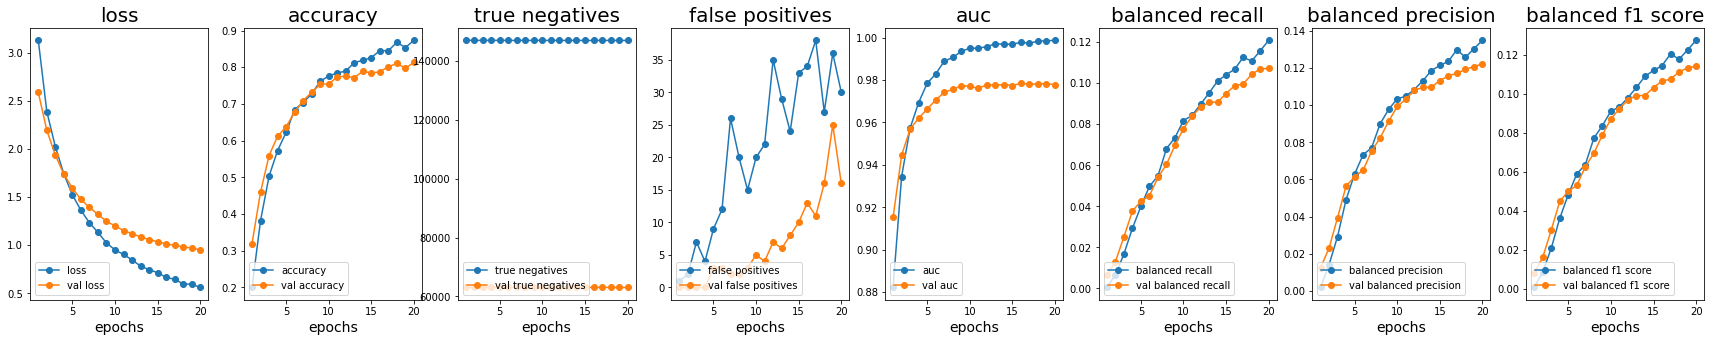

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [29]:
model_fit.history

{'loss': [3.1271939277648926,
  2.387040376663208,
  2.0234062671661377,
  1.7394813299179077,
  1.5228652954101562,
  1.3629263639450073,
  1.233515739440918,
  1.133041262626648,
  1.0235648155212402,
  0.9513223171234131,
  0.9038578867912292,
  0.847974956035614,
  0.7827392220497131,
  0.7464569807052612,
  0.7144826054573059,
  0.6658214926719666,
  0.6463637351989746,
  0.5978541374206543,
  0.5947838425636292,
  0.5614075064659119],
 'accuracy': [0.2001224011182785,
  0.38188493251800537,
  0.503059983253479,
  0.5728273987770081,
  0.6223990321159363,
  0.6842105388641357,
  0.7037943601608276,
  0.7270501852035522,
  0.7619339227676392,
  0.7760097980499268,
  0.7845777273178101,
  0.7894737124443054,
  0.8127294778823853,
  0.8188494443893433,
  0.8261933922767639,
  0.8451652526855469,
  0.8451652526855469,
  0.8678090572357178,
  0.8537331819534302,
  0.8733170032501221],
 'true_negatives': [147059.0,
  147058.0,
  147053.0,
  147056.0,
  147051.0,
  147048.0,
  147034.0,


### Predictions

In [53]:
#predict class function
def predict_class(test_text):
  '''predict class of input text
  Args:
    - comments (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in bert_model.predict(test_text)]

In [55]:
data_red.head(10)

,ict_components,desc_strip_nofmt
2035,02-09 SourceCatalogue 02-09-02 SourceCatalogue...,From [PRTSPR-49908|https://jira.alma.cl/browse...
1724,03-04 DataCapturer,This issue has been reported at https://jira.a...
2176,11 SSR 11-04 Calibrator queries,From [PRTSPR-45202|https://jira.alma.cl/browse...
915,03-02 Baseline Correlator,http://jira.alma.cl/browse/PRTSPR-26108 report...
2025,"12-02 ACS Manager, Component, Container, Client",A container crash happend during CYCLE4 Observ...
949,03 Control,TotalPower container crashed as reported in [P...
1620,07 Operations Software Support,An alerting system should be implemented in or...
1106,"12-02 ACS Manager, Component, Container, Client",Transferring from [PRTSIR-5373|http://jira.alm...
2291,03 Control,It was noticed in [PRTSPR-41783|https://jira.a...
554,"12-02 ACS Manager, Component, Container, Client",While using {{Acspy.Common.EpochHelper}} libra...


In [121]:
sw_map=dict(zip([str(n) for n in range(0,len(y_cat_labels[1]))] , y_cat_labels[1].values))
sw_map


{'0': '02-09 SourceCatalogue 02-09-02 SourceCatalogue webui',
 '1': '03-04 DataCapturer',
 '2': '11 SSR 11-04 Calibrator queries',
 '3': '03-02 Baseline Correlator',
 '4': '12-02 ACS Manager, Component, Container, Client',
 '5': '03 Control',
 '6': '07 Operations Software Support',
 '7': '12-05 Notification Channel',
 '8': '07 Operations Software Support 12-06 BulkData Handling',
 '9': '01 ACA Control',
 '10': '10 Telescope Calibration (TelCal)',
 '11': '07-08 AOSCheck',
 '12': '06-05 Aqua/QA2',
 '13': '07-02 DevOps',
 '14': '01-01 ACA Correlator',
 '15': '03-01 Antenna, LO and Timing HW',
 '16': '01 ACA Control 03-02 Baseline Correlator',
 '17': '10 Telescope Calibration (TelCal) 12-02 ACS Manager, Component, Container, Client',
 '18': '07-09 AOSCheck Dashboard',
 '19': '12-07 Third-party products',
 '20': '12-06 BulkData Handling',
 '21': '12-03 Logging and Error System',
 '22': '07 Operations Software Support 12-02 ACS Manager, Component, Container, Client',
 '23': '02 Archive Servi

## Predict eng_location

In [32]:
predict_class([data_red['desc_strip_nofmt'][50]])

1/1 [==============================] - 1s 1s/step


[5]

## Review PRTSIR description sentence

In [33]:
[data_red['desc_strip_nofmt'][50]]

['Sometimes when an Array is being destroyed it takes more time than usual to stop the corresponding TOTALPOWER component or there is an error, ending up in the next created array to use an already used TotalPowerStream. This results in a BD Frame ACK timeout when data is tried to be transmitted from the TotalPower sender to the receivers.\n\nFor example, in the following logs Array001 used TotalPowerStream2:\n']

## Review PRTSPRT eng_location (true value)

In [42]:
[data_red['ict_components'][50]]

['03 Control']

## Map encoded (categorical data) to eng_location description

In [ ]:
sw_map[sw_map['label']==55]

In [109]:
sample_df = data.sample(n=5)
sample_df.head()

,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware0_value,eng_hardware1_value,eng_hardware2_value,...,eng_location2_value,ict_components_0,ict_components_1,ict_components_2,ict_components,ict_description,ict_summary,desc_strip_nl,desc_strip_nl_nl,desc_strip_nofmt
2173,ICT-12911,PRTSPR-33921,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,03 Control,03-02 Baseline Correlator,NaN,03 Control 03-02 Baseline Correlator,As described at https://jira.alma.cl/browse/PR...,195 long sub-scan sequence fails to run,As described at https://jira.alma.cl/browse/PR...,As described at https://jira.alma.cl/browse/PR...,As described at https://jira.alma.cl/browse/PR...
1655,ICT-8579,PRTSPR-23523,NaN,lorenzo.mconde@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,"03-01 Antenna, LO and Timing HW",NaN,NaN,"03-01 Antenna, LO and Timing HW",I think there is a subtle problem with the alg...,IFProcImpl::setPowerLevel robustness problem w...,I think there is a subtle problem with the alg...,I think there is a subtle problem with the alg...,I think there is a subtle problem with the alg...
890,ICT-7311,PRTSPR-37822,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,01 ACA Control,12-06 BulkData Handling,NaN,01 ACA Control 12-06 BulkData Handling,Edited: I changed the original description of ...,ACA: BD Frame Ack Timeout after a startSend error,Edited: I changed the original description of ...,Edited: I changed the original description of ...,Edited: I changed the original description of ...
1254,ICT-13055,PRTSPR-32717,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,NaN,12-06 BulkData Handling,NaN,NaN,12-06 BulkData Handling,After some discussion (See [ICT-12736|https://...,BulkData startSend method should offer a defau...,After some discussion (See [ICT-12736|https://...,After some discussion (See [ICT-12736|https://...,After some discussion (See [ICT-12736|https://...
1504,ICT-17382,PRTSPR-59744,NaN,nicolas.pena@alma.cl,Resolved,NaN,NaN,NaN,NaN,NaN,...,NaN,"03-01 Antenna, LO and Timing HW",NaN,NaN,"03-01 Antenna, LO and Timing HW",Update IFSwitch spreadsheet (FrontEnd/IFSwitc...,Update ICD spreadsheet (4/6) : IFSwitch,Update IFSwitch spreadsheet (FrontEnd/IFSwitc...,Update IFSwitch spreadsheet (FrontEnd/IFSwitc...,Update IFSwitch spreadsheet (FrontEnd/IFSwitc...


## Append to Sample DF

In [110]:
test_list=[]

#for idx,value in sample_df['re_sentence1'].iteritems():
for idx,value in sample_df['desc_strip_nofmt'].iteritems():

    #print(value)
    
    if isinstance(value,str) == True:
        
        list_value = [np.argmax(pred) for pred in bert_model.predict([value])]
        test_list.append(list_value[0])
    
    else:
        test_list.append('No Pred.')
        continue


#print(test_list)


#append to data frame
sample_df['Predictions'] = np.array(test_list)

#map coded hardware
sample_df['Predictions'] = sample_df['Predictions'].map(sw_map)
sample_df


1/1 [==============================] - 0s 56ms/step


,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware0_value,eng_hardware1_value,eng_hardware2_value,...,ict_components_0,ict_components_1,ict_components_2,ict_components,ict_description,ict_summary,desc_strip_nl,desc_strip_nl_nl,desc_strip_nofmt,Predictions
2173,ICT-12911,PRTSPR-33921,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,03 Control,03-02 Baseline Correlator,NaN,03 Control 03-02 Baseline Correlator,As described at https://jira.alma.cl/browse/PR...,195 long sub-scan sequence fails to run,As described at https://jira.alma.cl/browse/PR...,As described at https://jira.alma.cl/browse/PR...,As described at https://jira.alma.cl/browse/PR...,03 Control 03-02 Baseline Correlator
1655,ICT-8579,PRTSPR-23523,NaN,lorenzo.mconde@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,"03-01 Antenna, LO and Timing HW",NaN,NaN,"03-01 Antenna, LO and Timing HW",I think there is a subtle problem with the alg...,IFProcImpl::setPowerLevel robustness problem w...,I think there is a subtle problem with the alg...,I think there is a subtle problem with the alg...,I think there is a subtle problem with the alg...,"03-01 Antenna, LO and Timing HW"
890,ICT-7311,PRTSPR-37822,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,01 ACA Control,12-06 BulkData Handling,NaN,01 ACA Control 12-06 BulkData Handling,Edited: I changed the original description of ...,ACA: BD Frame Ack Timeout after a startSend error,Edited: I changed the original description of ...,Edited: I changed the original description of ...,Edited: I changed the original description of ...,01 ACA Control 12-06 BulkData Handling
1254,ICT-13055,PRTSPR-32717,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,12-06 BulkData Handling,NaN,NaN,12-06 BulkData Handling,After some discussion (See [ICT-12736|https://...,BulkData startSend method should offer a defau...,After some discussion (See [ICT-12736|https://...,After some discussion (See [ICT-12736|https://...,After some discussion (See [ICT-12736|https://...,03 Control
1504,ICT-17382,PRTSPR-59744,NaN,nicolas.pena@alma.cl,Resolved,NaN,NaN,NaN,NaN,NaN,...,"03-01 Antenna, LO and Timing HW",NaN,NaN,"03-01 Antenna, LO and Timing HW",Update IFSwitch spreadsheet (FrontEnd/IFSwitc...,Update ICD spreadsheet (4/6) : IFSwitch,Update IFSwitch spreadsheet (FrontEnd/IFSwitc...,Update IFSwitch spreadsheet (FrontEnd/IFSwitc...,Update IFSwitch spreadsheet (FrontEnd/IFSwitc...,"03-01 Antenna, LO and Timing HW"


## Append to original dataframe

In [111]:
test_list=[]

#for idx,value in data['re_sentence1'].iteritems():
for idx,value in data['desc_strip_nofmt'].iteritems():

   
    if isinstance(value,str) == True:
        
        list_value = [np.argmax(pred) for pred in bert_model.predict([value])]
        test_list.append(list_value[0])
    
    else:
        test_list.append('No Pred.')
        continue



#append to data frame
data['Predictions'] = np.array(test_list)

#map coded hardware
data['Predictions'] = data['Predictions'].map(sw_map)
data

1/1 [==============================] - 0s 56ms/step


,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware0_value,eng_hardware1_value,eng_hardware2_value,...,ict_components_0,ict_components_1,ict_components_2,ict_components,ict_description,ict_summary,desc_strip_nl,desc_strip_nl_nl,desc_strip_nofmt,Predictions
0,ICT-3010,PRTSPR-21519,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,07 Operations Software Support,NaN,NaN,07 Operations Software Support,During the execution of the following observat...,Mount command executed in the wrong timing event,During the execution of the following observat...,During the execution of the following observat...,During the execution of the following observat...,NaN
1,ICT-761,PRTSPR-36175,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,03 Control,NaN,NaN,03 Control,The crash was because ambInterface failed at s...,"Antenna cppContainer down, segfault at AmbInte...",The crash was because ambInterface failed at s...,The crash was because ambInterface failed at s...,The crash was because ambInterface failed at s...,NaN
2,ICT-15155,PRTSPR-42844,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,07 Operations Software Support,NaN,NaN,07 Operations Software Support,"During the report of PRTSPR-42844, we noted th...",Shiftlog: store the log of the created shiftlo...,"During the report of PRTSPR-42844, we noted th...","During the report of PRTSPR-42844, we noted th...","During the report of PRTSPR-42844, we noted th...",NaN
3,ICT-20937,PRTSPR-62266,NaN,immer@strw.leidenuniv.nl,Open,NaN,NaN,NaN,NaN,NaN,...,03 Control,NaN,NaN,03 Control,Right now we have 10 known instances of duplic...,Duplicated uid for consecutive EB's,Right now we have 10 known instances of duplic...,Right now we have 10 known instances of duplic...,Right now we have 10 known instances of duplic...,NaN
4,ICT-9606,PRTSPR-25225,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,12-01 Alarm System and Monitoring,NaN,NaN,12-01 Alarm System and Monitoring,In http://jira.alma.cl/browse/PRTSPR-25225 it ...,Antenna crash on TMCDB::MonitorCollectorImpl::...,In http://jira.alma.cl/browse/PRTSPR-25225 it ...,In http://jira.alma.cl/browse/PRTSPR-25225 it ...,In http://jira.alma.cl/browse/PRTSPR-25225 it ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,ICT-9762,PRTSPR-25226,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,07 Operations Software Support,NaN,NaN,07 Operations Software Support,There have been a few instances of Archive cra...,Archive runing out of memmory,There have been a few instances of Archive cra...,There have been a few instances of Archive cra...,There have been a few instances of Archive cra...,NaN
2332,ICT-5721,PRTSPR-26898,"[""AntennaContainerCrash""]",software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,12-01 Alarm System and Monitoring,NaN,NaN,12-01 Alarm System and Monitoring,DA52 container crashed with the following BT:\...,Antenna container crash destroying a MonitorBlob,DA52 container crashed with the following BT:,DA52 container crashed with the following BT:\...,DA52 container crashed with the following BT:\n,NaN
2333,ICT-9810,PRTSPR-29658,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,03-05 QuickLook,NaN,NaN,03-05 QuickLook,"During observations, it happens that sometimes...",Sometimes Quicklook starts repeating uid entri...,"During observations, it happens that sometimes...","During observations, it happens that sometimes...","During observations, it happens that sometimes...",NaN
2334,ICT-11530,PRTSPR-29834,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,07 Operations Software Support,NaN,NaN,07 Operations Software Support,This ticket has a a purpose to determine the e...,Patch compilation and deployment procedure,This ticket has a a purpose to determine the e...,This ticket has a a purpose to determine the e...,This ticket has a a purpose to determine the e...,NaN


In [119]:
data['Predictions'] = np.array(test_list)

In [123]:
data['Predictions']

0                              03 Control
1                              03 Control
2          07 Operations Software Support
3                              03 Control
4       12-01 Alarm System and Monitoring
                      ...                
2331       07 Operations Software Support
2332    12-01 Alarm System and Monitoring
2333                      03-05 QuickLook
2334       07 Operations Software Support
2335                           03 Control
Name: Predictions, Length: 2336, dtype: object

In [122]:
data['Predictions'] = data['Predictions'].map(sw_map)

In [118]:
test_list

[5,
 5,
 6,
 5,
 28,
 24,
 28,
 24,
 28,
 28,
 11,
 24,
 5,
 11,
 11,
 11,
 25,
 6,
 5,
 5,
 6,
 24,
 5,
 11,
 11,
 11,
 11,
 5,
 5,
 7,
 5,
 5,
 15,
 6,
 28,
 7,
 11,
 11,
 11,
 5,
 25,
 5,
 5,
 5,
 18,
 15,
 5,
 3,
 5,
 24,
 5,
 28,
 28,
 28,
 28,
 7,
 11,
 11,
 7,
 11,
 5,
 7,
 5,
 5,
 5,
 5,
 5,
 24,
 5,
 5,
 28,
 24,
 28,
 28,
 11,
 11,
 5,
 10,
 5,
 5,
 5,
 15,
 25,
 5,
 28,
 24,
 7,
 11,
 11,
 5,
 5,
 25,
 5,
 5,
 7,
 5,
 15,
 3,
 5,
 24,
 28,
 28,
 24,
 24,
 24,
 24,
 5,
 11,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 15,
 25,
 5,
 5,
 24,
 6,
 24,
 11,
 11,
 5,
 61,
 5,
 5,
 6,
 5,
 5,
 5,
 5,
 6,
 11,
 24,
 7,
 11,
 11,
 33,
 4,
 33,
 4,
 19,
 4,
 4,
 5,
 3,
 4,
 4,
 4,
 5,
 3,
 33,
 4,
 10,
 11,
 37,
 66,
 33,
 9,
 4,
 5,
 5,
 5,
 4,
 33,
 5,
 4,
 5,
 4,
 38,
 33,
 33,
 29,
 11,
 4,
 6,
 5,
 5,
 4,
 33,
 4,
 4,
 4,
 19,
 11,
 5,
 4,
 10,
 10,
 37,
 11,
 37,
 62,
 3,
 10,
 4,
 4,
 4,
 29,
 11,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 5,
 15,
 15,
 9,
 5,
 10,
 5,
 11,
 5,
 5,
 3,
 5,
 5,
 5,
 5,
 5,
 

In [124]:
data

,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware0_value,eng_hardware1_value,eng_hardware2_value,...,ict_components_0,ict_components_1,ict_components_2,ict_components,ict_description,ict_summary,desc_strip_nl,desc_strip_nl_nl,desc_strip_nofmt,Predictions
0,ICT-3010,PRTSPR-21519,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,07 Operations Software Support,NaN,NaN,07 Operations Software Support,During the execution of the following observat...,Mount command executed in the wrong timing event,During the execution of the following observat...,During the execution of the following observat...,During the execution of the following observat...,03 Control
1,ICT-761,PRTSPR-36175,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,03 Control,NaN,NaN,03 Control,The crash was because ambInterface failed at s...,"Antenna cppContainer down, segfault at AmbInte...",The crash was because ambInterface failed at s...,The crash was because ambInterface failed at s...,The crash was because ambInterface failed at s...,03 Control
2,ICT-15155,PRTSPR-42844,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,07 Operations Software Support,NaN,NaN,07 Operations Software Support,"During the report of PRTSPR-42844, we noted th...",Shiftlog: store the log of the created shiftlo...,"During the report of PRTSPR-42844, we noted th...","During the report of PRTSPR-42844, we noted th...","During the report of PRTSPR-42844, we noted th...",07 Operations Software Support
3,ICT-20937,PRTSPR-62266,NaN,immer@strw.leidenuniv.nl,Open,NaN,NaN,NaN,NaN,NaN,...,03 Control,NaN,NaN,03 Control,Right now we have 10 known instances of duplic...,Duplicated uid for consecutive EB's,Right now we have 10 known instances of duplic...,Right now we have 10 known instances of duplic...,Right now we have 10 known instances of duplic...,03 Control
4,ICT-9606,PRTSPR-25225,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,12-01 Alarm System and Monitoring,NaN,NaN,12-01 Alarm System and Monitoring,In http://jira.alma.cl/browse/PRTSPR-25225 it ...,Antenna crash on TMCDB::MonitorCollectorImpl::...,In http://jira.alma.cl/browse/PRTSPR-25225 it ...,In http://jira.alma.cl/browse/PRTSPR-25225 it ...,In http://jira.alma.cl/browse/PRTSPR-25225 it ...,12-01 Alarm System and Monitoring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,ICT-9762,PRTSPR-25226,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,07 Operations Software Support,NaN,NaN,07 Operations Software Support,There have been a few instances of Archive cra...,Archive runing out of memmory,There have been a few instances of Archive cra...,There have been a few instances of Archive cra...,There have been a few instances of Archive cra...,07 Operations Software Support
2332,ICT-5721,PRTSPR-26898,"[""AntennaContainerCrash""]",software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,12-01 Alarm System and Monitoring,NaN,NaN,12-01 Alarm System and Monitoring,DA52 container crashed with the following BT:\...,Antenna container crash destroying a MonitorBlob,DA52 container crashed with the following BT:,DA52 container crashed with the following BT:\...,DA52 container crashed with the following BT:\n,12-01 Alarm System and Monitoring
2333,ICT-9810,PRTSPR-29658,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,03-05 QuickLook,NaN,NaN,03-05 QuickLook,"During observations, it happens that sometimes...",Sometimes Quicklook starts repeating uid entri...,"During observations, it happens that sometimes...","During observations, it happens that sometimes...","During observations, it happens that sometimes...",03-05 QuickLook
2334,ICT-11530,PRTSPR-29834,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,07 Operations Software Support,NaN,NaN,07 Operations Software Support,This ticket has a a purpose to determine the e...,Patch compilation and deployment procedure,This ticket has a a purpose to det

In [77]:
data.to_csv('software_predictions.csv')

In [102]:
data.sample(n=10)

,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware0_value,eng_hardware1_value,eng_hardware2_value,...,ict_components_0,ict_components_1,ict_components_2,ict_components,ict_description,ict_summary,desc_strip_nl,desc_strip_nl_nl,desc_strip_nofmt,Predictions
651,ICT-9866,PRTSPR-27366,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,10 Telescope Calibration (TelCal),12-05 Notification Channel,NaN,10 Telescope Calibration (TelCal) 12-05 Notifi...,"In http://jira.alma.cl/browse/PRTSPR-25900, TE...","TELCAL: No events received, and no scan processed","In http://jira.alma.cl/browse/PRTSPR-25900, TE...","In http://jira.alma.cl/browse/PRTSPR-25900, TE...","In http://jira.alma.cl/browse/PRTSPR-25900, TE...",NaN
1170,ICT-4783,PRTSPR-21210,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,"12-02 ACS Manager, Component, Container, Client",NaN,NaN,"12-02 ACS Manager, Component, Container, Client",Transferring from [PRTSIR-5373|http://jira.alm...,"CONTROL: transient ""Error getting a reference ...",Transferring from [PRTSIR-5373|http://jira.alm...,Transferring from [PRTSIR-5373|http://jira.alm...,Transferring from [PRTSIR-5373|http://jira.alm...,NaN
96,ICT-15799,PRTSPR-45699,NaN,bill.dent@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,07-08 AOSCheck,NaN,NaN,07-08 AOSCheck,PRTSPR-45699 has 2 BB's. but is a spectral sca...,AOScheck with 2 BB's does not show bandpass am...,PRTSPR-45699 has 2 BB's. but is a spectral sca...,PRTSPR-45699 has 2 BB's. but is a spectral sca...,PRTSPR-45699 has 2 BB's. but is a spectral sca...,NaN
1069,ICT-19483,PRTSPR-55718,NaN,sergio.otarola@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,"03-01 Antenna, LO and Timing HW",NaN,NaN,"03-01 Antenna, LO and Timing HW",At [https://jira.alma.cl/browse/PRTSPR-53536] ...,Failure to obtain OptimizeSinglePolThread lead...,At [https://jira.alma.cl/browse/PRTSPR-53536] ...,At [https://jira.alma.cl/browse/PRTSPR-53536] ...,At [https://jira.alma.cl/browse/PRTSPR-53536] ...,NaN
1099,ICT-8787,PRTSPR-36324,"[""AntennaContainerCrash""]",software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,07 Operations Software Support,NaN,NaN,07 Operations Software Support,There might be different sources for memory co...,Investigate why antennas crash from time to ti...,There might be different sources for memory co...,There might be different sources for memory co...,There might be different sources for memory co...,NaN
1916,ICT-13502,PRTSPR-36269,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,07 Operations Software Support,NaN,NaN,07 Operations Software Support,I'm creating this ICT ticket with the analysis...,Several DA antennas with no pointing data,I'm creating this ICT ticket with the analysis...,I'm creating this ICT ticket with the analysis...,I'm creating this ICT ticket with the analysis...,NaN
1797,ICT-4841,PRTSPR-48384,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,01 ACA Control,NaN,NaN,01 ACA Control,"During ES time, When running a bandpass calibr...",ACACORR/CDPMIF/MASTER Not found channel averag...,"During ES time, When running a bandpass calibr...","During ES time, When running a bandpass calibr...","During ES time, When running a bandpass calibr...",NaN
1707,ICT-7893,PRTSPR-21036,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,02-12 Archive Online Chain,NaN,NaN,02-12 Archive Online Chain,During the investigation of [PRTSPR-21036|http...,ABR: Archive receivers wrongly share the buffe...,During the investigation of [PRTSPR-21036|http...,During the investigation of [PRTSPR-21036|http...,During the investigation of [PRTSPR-21036|http...,NaN
1934,ICT-19033,PRTSPR-36992,NaN,ade-amg-supervisors@alma.cl,Closed,NaN,NaN,NaN,NaN,NaN,...,"03-01 Antenna, LO and Timing HW",NaN,NaN,"03-01 Antenna, LO and Timing HW",Revision D of the front-end to control softwar...,Set all IF switch attenuators at once,Revision D of the front-end to control softwar...,Revision D of the front-end to control softwar...,

# plotly chart thar

In [95]:
data['correct_hw'] = np.where(data['eng_hardware'] == data['Predictions'],1,0)

In [98]:
data.sample(5)

,ticket,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware,eng_location,ict_components,PR_time_span_days,IR_time_span_days,ICT_time_span_days,ir_description,re_sentence1,Predictions,Correct_Hardware,correct_hw
7490,PRTSPR-37605,PRTSIR-14122,PRTSPR-37605,NaN,ade-amg-supervisors@alma.cl,Closed,True,ade-amg-supervisors@alma.cl,DV11,CCA7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
6603,PRTSPR-34336,PRTSIR-13481,PRTSPR-34336,NaN,ade-amg-supervisors@alma.cl,Closed,False,pzorzi@alma.cl,DV05,CCA3.WCA3,NaN,NaN,35.0,NaN,NaN,NaN,NaN,0,0
9995,PRTSPR-34335,PRTSIR-9588,PRTSPR-34335,NaN,daniel.herrera@alma.cl,Closed,True,mwatanab,AOS ACA Corr Room,ACA MCI Module,NaN,NaN,NaN,NaN,*TimeStamp:* \nAfter the most recent FSR ACACo...,"[""*TimeStamp:* ""]",DV18,0,0
12258,PRTSPR-45603,PRTSIR-15881,PRTSPR-45603,NaN,ade-amg-supervisors@alma.cl,Closed,True,ppuelles@alma.cl,DV06,Antenna Shutter,NaN,NaN,NaN,NaN,cannot open the shutter and for that cannot be...,"[""cannot open the shutter and for that cannot ...",AOS ACA Corr Room,0,0
10785,PRTSPR-30444,PRTSIR-10321,PRTSPR-30444,NaN,jgatica@alma.cl,Closed,True,lmconde,NaN,NaN,NaN,NaN,NaN,NaN,Data reception errors (Lane frame receive err...,"[""Data reception errors (Lane frame receive e...",AOS ACA Corr Room,0,0


In [99]:
hw_cnt_df = pd.DataFrame(data.groupby('eng_hardware').size().sort_values(ascending=False)).reset_index().rename(columns={0:'total_label_count'})
hw_cnt_df

,eng_hardware,total_label_count
0,AOS ACA Corr Room,753
1,DV04,531
2,AOS,362
3,AOS BL Corr Room,219
4,DV10,163
...,...,...
211,DA41.DA56.DA60,1
212,DA41.DA49.DA50,1
213,CM09.AOS,1
214,CM08.DA50.DV08,1


In [101]:
hw_correct = pd.DataFrame(data.groupby('Predictions').agg({'correct_hw':'sum'}).sort_values(by='correct_hw',ascending=False)).reset_index().rename(columns={'Predictions':'eng_hardware'})
#hw_correct=hw_correct.rename(columns={'Predictions':'eng_hardware'}, axis=1)
hw_correct

,eng_hardware,correct_hw
0,AOS ACA Corr Room,644
1,DV04,404
2,AOS,244
3,AOS BL Corr Room,147
4,CM11,109
...,...,...
168,DA42.AOS64,1
169,DA41.DA56.DA64,1
170,DA41.DA49.DA50,1
171,CM09.AOS,1


In [164]:
hw_acc_df=pd.merge(hw_cnt_df,hw_correct,
                   on='eng_hardware',
                   how='outer')
hw_acc_df['pct_correct'] = 100*(hw_acc_df['correct_hw'] / hw_acc_df['total_label_count']).round(3)
hw_acc_df=hw_acc_df.sort_values(by='total_label_count',ascending=False).reset_index()
hw_acc_df

,index,eng_hardware,total_label_count,correct_hw,pct_correct
0,0,AOS ACA Corr Room,753,644.0,85.5
1,1,DV04,531,404.0,76.1
2,2,AOS,362,244.0,67.4
3,3,AOS BL Corr Room,219,147.0,67.1
4,4,DV10,163,41.0,25.2
...,...,...,...,...,...
211,155,CM02.CM03.CM04,1,1.0,100.0
212,154,CM02.CM08,1,1.0,100.0
213,153,CM03.CM04.CM05,1,NaN,NaN
214,152,CM03.CM07,1,1.0,100.0


## Plotly bar chart

In [105]:
import plotly.express as px
from plotly.subplots import make_subplots

In [165]:
from plotly.subplots import make_subplots

fig = make_subplots(shared_yaxes=True, shared_xaxes=True)

fig.add_bar(x=hw_acc_df['total_label_count'].head(10), y=hw_acc_df['eng_hardware'].head(10), opacity=0.6, width=0.7, name='Total Count', hovertemplate='%{y}',  orientation='h')
fig.add_bar(x=hw_acc_df['correct_hw'].head(10), y=hw_acc_df['eng_hardware'].head(10), width=0.5, name='% Accurate',text=hw_acc_df['pct_correct'], textposition='outside', orientation='h')

fig.update_layout(barmode='overlay', 
                  title= "Model Performance (Correct Classification)<br><sup>Accuracy% = Correct/Total</sup>",
                  xaxis_title='Hardware Issues', 
                  yaxis_title='Hardware',
                  yaxis=dict(autorange="reversed"))


fig.show()

In [169]:
import scipy.metrics

ModuleNotFoundError: No module named 'scipy.metrics'

In [176]:
x = [2, 5, 4, 7, 3]

w = [.8, 1.2, .65, 1.45, .3]

In [177]:
x*w

TypeError: can't multiply sequence by non-int of type 'list'